#<u> Introduction </u>
### To predict the number of units sold in next 12 month based on previous month sales

##<u>Given Data:</u>
### Sale Record of 42 months

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
data = pd.read_csv('Forecasting_Case_Study_Data.csv')
data = data.iloc[:42] #taking the first 42 rows in data ( because the others are empty)
from datetime import datetime

# Convert 'Time' to datetime and set it as index
data['Time'] = pd.to_datetime(data['Time'], format='%Y_Month_%m')
data.set_index('Time', inplace=True)

data.to_csv('Forecasting_Date_Time.csv',index=False)

In [ ]:
np.median(data['Actuals'])

365398.0

In [ ]:
# Removing 3 outliers - 40k,41k,70k (Experimented)
data2=pd.read_csv('Forecasting_Case_Study_Data_2.csv')
data2 = data2.iloc[:39]
data2.to_csv('Without_Outlier.csv',index=False)
data2['Time'] = pd.to_datetime(data2['Time'], format='%Y_Month_%m')
data2.set_index('Time', inplace=True)

# ADF Test for Stationarity

## ADF is Augmented-Dickey Fuller Test, it is a statistical test for checking the stationarity of the data.

In [ ]:
#KPSS
from statsmodels.tsa.stattools import kpss


def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

kpss_test(data['Actuals'])

Results of KPSS Test:
Test Statistic           0.23314
p-value                  0.10000
Lags Used                4.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


<ipython-input-5-1aa37c56fa7e>:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
# Call the function and run the test

adf_test(data['Actuals'])
adf_test(data2['Actuals'])

Results of Dickey-Fuller Test:
Test Statistic                -6.435037e+00
p-value                        1.660927e-08
#Lags Used                     0.000000e+00
Number of Observations Used    4.100000e+01
Critical Value (1%)           -3.600983e+00
Critical Value (5%)           -2.935135e+00
Critical Value (10%)          -2.605963e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -3.626783
p-value                         0.005269
#Lags Used                      2.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


# Conclusion:

## Both tests indicate stationarity.
Case 1: Both tests conclude that the series is not stationary - The series is not stationary

Case 2: Both tests conclude that the series is stationary - The series is stationary

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

# seasonal_decompose()

Additive:
y(t) = Level + Trend + Seasonality + Noise

Multiplicative:
y(t) = Level * Trend * Seasonality * Noise

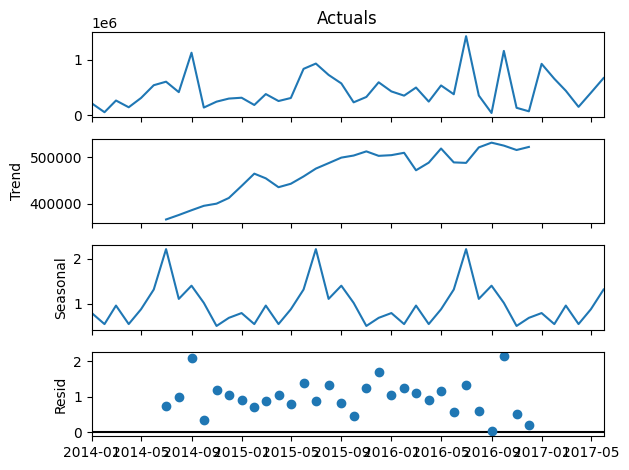

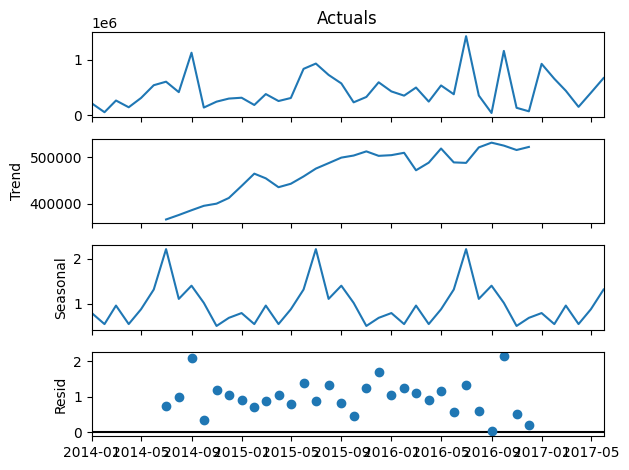

In [ ]:
#Checking for trends
decompose_result = seasonal_decompose(data['Actuals'], model = 'multiplicative', period=12)
decompose_result.plot()

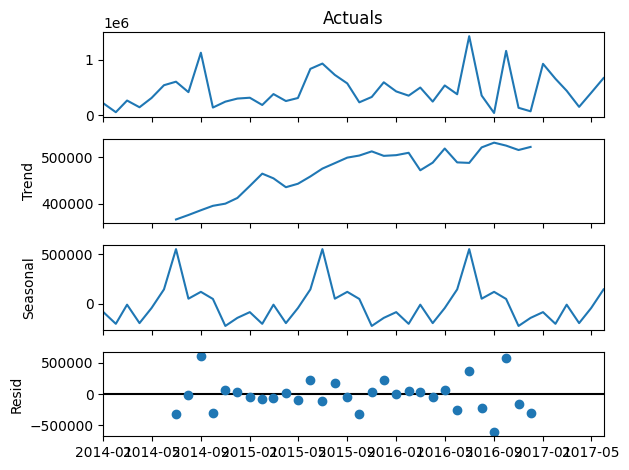

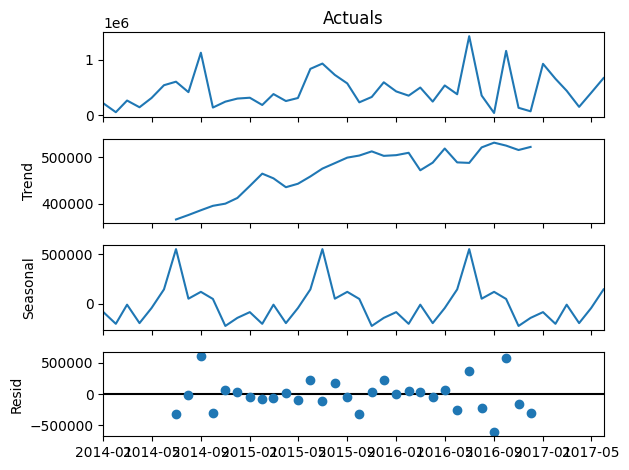

In [ ]:
#Checking for trends
decompose_result = seasonal_decompose(data['Actuals'], model = 'additive', period=12)
decompose_result.plot()

# Simple Exponential Smoothing

Smoothing Factor (α): This parameter controls the extent of smoothing applied to the time series data. It is a value between 0 and 1, representing the weight assigned to the most recent observation when calculating the forecast. A smaller α gives more weight to older observations, resulting in less responsiveness to recent changes in the data. Conversely, a larger α gives more weight to recent observations, making the forecast more responsive to changes.

F(t+1)=F(t)+ α(A(t)-F(t))

F(t+1)=next forecast
F(t)=present forecast
A(t)=Actual value


General Guideline:

If the data contains a significant amount of noise or fluctuations, smaller value for α is chosen(e.g., closer to 0.1) to achieve a higher level of smoothing and filter out the noise effectively.

If the data has less noise and a more responsive forecast that closely tracks the recent observations is needed , then a slightly larger value for α (e.g., closer to 0.3) to give more weight to the recent observations while still maintaining some level of smoothing.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: title={'center': 'Holt Winters Single Exponential Smoothing'}, xlabel='Time'>

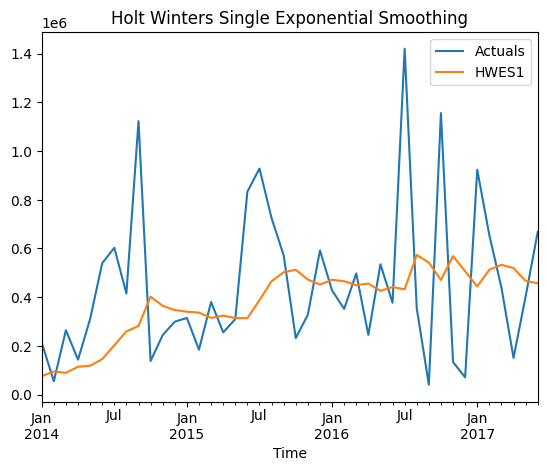

In [ ]:
data['HWES1'] = SimpleExpSmoothing(data['Actuals'],initialization_method='estimated').fit().fittedvalues

data[['Actuals', 'HWES1']].plot(title = 'Holt Winters Single Exponential Smoothing')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: title={'center': 'Holt Winters Single Exponential Smoothing'}, xlabel='Time'>

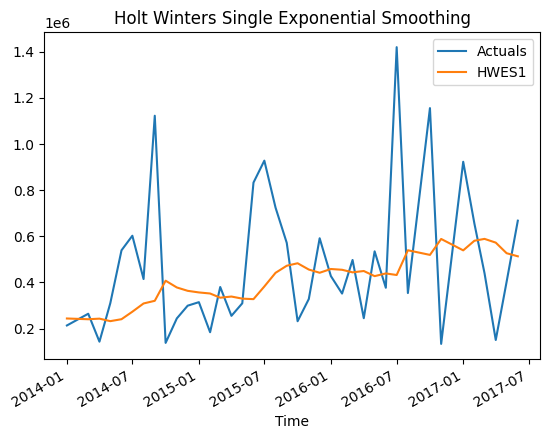

In [ ]:
data2['HWES1'] = SimpleExpSmoothing(data2['Actuals'],initialization_method='estimated').fit().fittedvalues

data2[['Actuals', 'HWES1']].plot(title = 'Holt Winters Single Exponential Smoothing')

# Double Exponential Smoothing




It is the recursive application of an exponential filter twice, thus being termed "double exponential smoothing".

L(t+1)=L(t)+ α(A(t)-L(t))

B(t)=(1-β)B(t-1)+β(L(t)-L(t-1))



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: title={'center': 'Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend'}, xlabel='Time'>

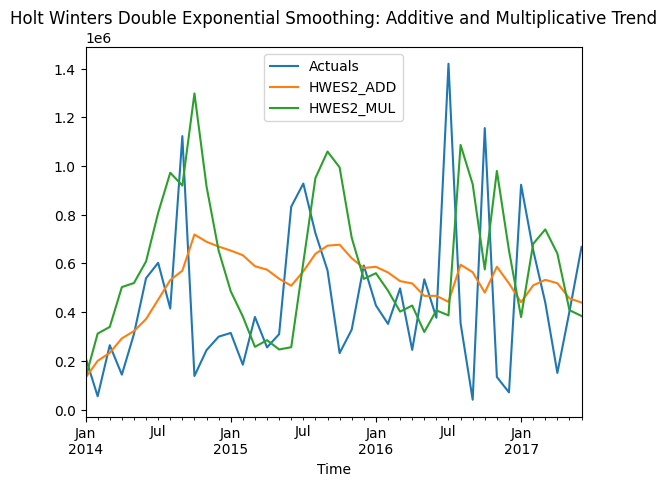

In [ ]:
data['HWES2_ADD'] = ExponentialSmoothing(data['Actuals'],initialization_method='estimated' ,trend = 'add').fit().fittedvalues

data['HWES2_MUL'] = ExponentialSmoothing(data['Actuals'], initialization_method='estimated',trend = 'mul').fit().fittedvalues

data[['Actuals', 'HWES2_ADD', 'HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: title={'center': 'Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend'}, xlabel='Time'>

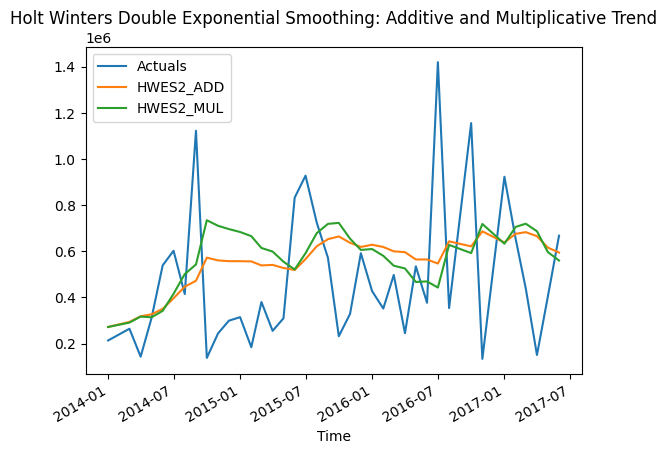

In [ ]:
data2['HWES2_ADD'] = ExponentialSmoothing(data2['Actuals'], trend = 'add').fit().fittedvalues

data2['HWES2_MUL'] = ExponentialSmoothing(data2['Actuals'], trend = 'mul').fit().fittedvalues

data2[['Actuals', 'HWES2_ADD', 'HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend')

# Triple Exponential Smoothing

Triple exponential smoothing extends double exponential smoothing by incorporating a seasonal component in addition to the level and trend components.

St = α × (Xt − Ct−L) + (1 − α) × (St−1 + Bt−1)

Bt = β × (St − St−1) + (1 − β) × Bt−1

Ct = γ × (Xt − St) + (1 − γ) × Ct−L

Ft+m = St + m × Bt + Ct−L+1+((m−1)mod L)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: title={'center': 'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='Time'>

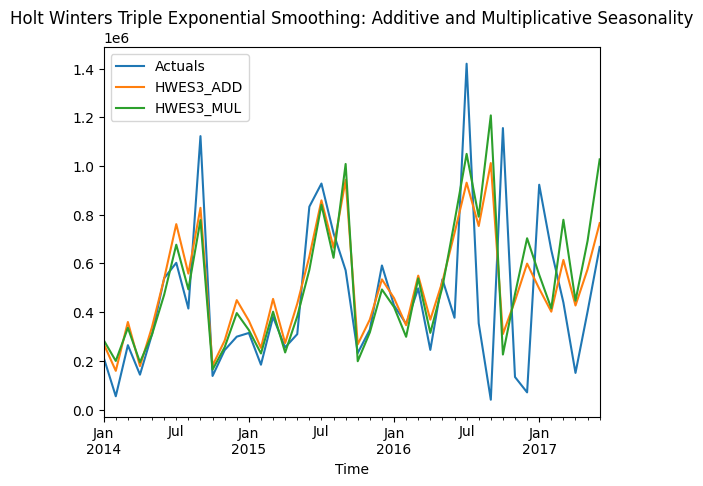

In [ ]:
data['HWES3_ADD'] = ExponentialSmoothing(data['Actuals'],initialization_method='estimated', trend = 'add', seasonal = 'add', seasonal_periods=12).fit().fittedvalues

data['HWES3_MUL'] = ExponentialSmoothing(data['Actuals'],initialization_method='estimated', trend = 'mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues

data[['Actuals', 'HWES3_ADD', 'HWES3_MUL']].plot(title = 'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: title={'center': 'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='Time'>

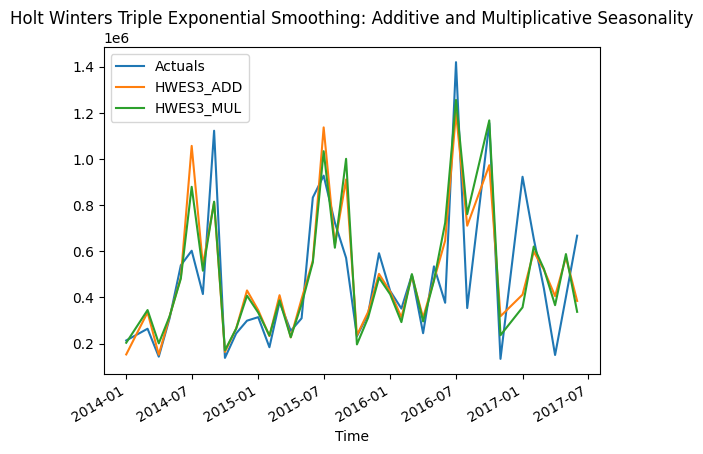

In [ ]:
data2['HWES3_ADD'] = ExponentialSmoothing(data2['Actuals'], trend = 'add', seasonal = 'add', seasonal_periods=12).fit().fittedvalues

data2['HWES3_MUL'] = ExponentialSmoothing(data2['Actuals'], trend = 'mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues

data2[['Actuals', 'HWES3_ADD', 'HWES3_MUL']].plot(title = 'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')

In [ ]:
train_data = data.iloc[:-int(len(data) * 0.2)]
test_data = data.iloc[-int(len(data) * 0.2):]
train_data2 = data2.iloc[:-int(len(data2) * 0.2)]
test_data2 = data2.iloc[-int(len(data2) * 0.2):]
print(test_data.shape)
print(test_data2.shape)

(8, 6)
(7, 6)


# Model Fitting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


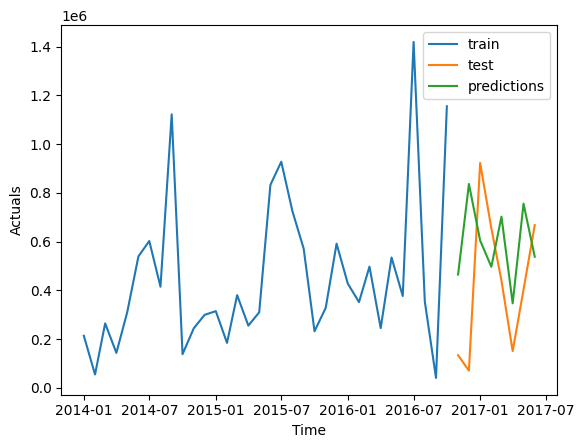

In [ ]:
fitted_model = ExponentialSmoothing(train_data['Actuals'], trend='mul', seasonal='mul', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(len(test_data))

import seaborn as sns

sns.lineplot(data=train_data, x=train_data.index, y='Actuals',label='train')
# train_data['Actuals'].plot(label='TRAIN')
sns.lineplot(data=test_data, x=test_data.index, y='Actuals',label='test')
# test_data['Actuals'].plot(label='TEST')
test_predictions.index = test_data.index
test_predictions = pd.DataFrame(test_predictions, columns=['Actuals'])

sns.lineplot(data=test_predictions, x=test_predictions.index, y='Actuals',label='predictions')
# test_predictions.plot(label='PREDICTION')

# print(test_predictions)

# plt.title('Train, Test and Predicted using Holt Winters')
plt.legend()
plt.show()

In [ ]:
test_predictions

,Actuals
Time,
2016-11-01,464797.646249
2016-12-01,836564.252371
2017-01-01,604665.985594
2017-02-01,496628.140186
2017-03-01,702320.763931
2017-04-01,346601.223016
2017-05-01,755649.846884
2017-06-01,537968.885723


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


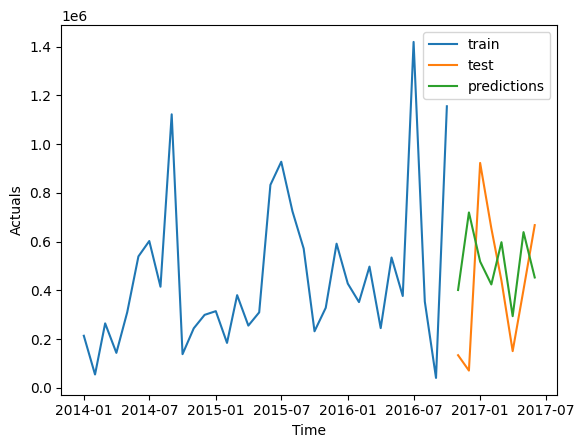

In [ ]:
fitted_model = ExponentialSmoothing(train_data['Actuals'], trend='add', seasonal='mul', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(len(test_data))

import seaborn as sns

sns.lineplot(data=train_data, x=train_data.index, y='Actuals',label='train')
# train_data['Actuals'].plot(label='TRAIN')
sns.lineplot(data=test_data, x=test_data.index, y='Actuals',label='test')
# test_data['Actuals'].plot(label='TEST')
test_predictions.index = test_data.index
test_predictions = pd.DataFrame(test_predictions, columns=['Actuals'])

sns.lineplot(data=test_predictions, x=test_predictions.index, y='Actuals',label='predictions')
# test_predictions.plot(label='PREDICTION')

# print(test_predictions)

# plt.title('Train, Test and Predicted using Holt Winters')
plt.legend()
plt.show()

In [ ]:
test_predictions

,Actuals
Time,
2016-11-01,401330.235052
2016-12-01,719803.046217
2017-01-01,518208.441548
2017-02-01,424208.941928
2017-03-01,597633.022227
2017-04-01,293901.413090
2017-05-01,639020.598503
2017-06-01,452771.637850


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


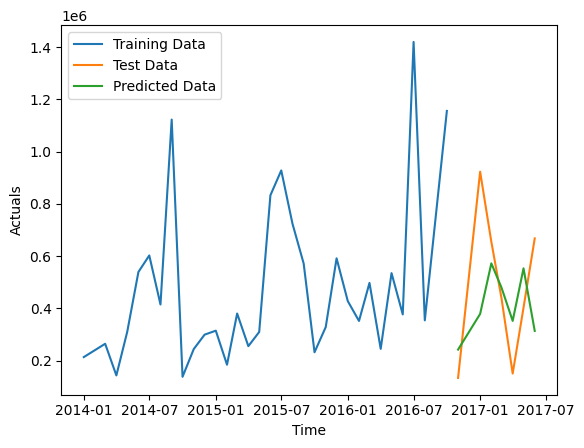

In [ ]:
fitted_model2 = ExponentialSmoothing(train_data2['Actuals'], trend='add', seasonal='mul', seasonal_periods=12).fit()
test_predictions2 = fitted_model2.forecast(len(test_data2))

import seaborn as sns

sns.lineplot(data=train_data2, x=train_data2.index, y='Actuals',label='Training Data')
# train_data['Actuals'].plot(label='TRAIN')
sns.lineplot(data=test_data2, x=test_data2.index, y='Actuals',label='Test Data')
# test_data['Actuals'].plot(label='TEST')
test_predictions2.index = test_data2.index
test_predictions2 = pd.DataFrame(test_predictions2, columns=['Actuals'])

sns.lineplot(data=test_predictions2, x=test_predictions2.index, y='Actuals',label='Predicted Data')
plt.legend()
plt.show()

In [ ]:
#Performance measure
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
def metrics(test,predictions):
   #mean forecast error
   forecast_errors = [test[i]-predictions[i] for i in range(len(test))]
   bias = sum(forecast_errors) * 1.0/len(test)
   #root mean squared error
   rmse = mean_squared_error(test, predictions,squared=False)
   #mean absolute error
   mae = mean_absolute_error(test, predictions)
   #mean absolute percentage error
   mape= mean_absolute_percentage_error(test, predictions)
   #root mean squared error
   rmsle = mean_squared_log_error(test, predictions,squared=False)
   print('Test Bias: %f' % bias)
   print('Test RMSE: %.3f' % rmse)
   print('Test RMSLE: %.3f' % rmsle)
   print('Test MAE: %f' % mae)
   print('Test mape: %.3f' % mape)

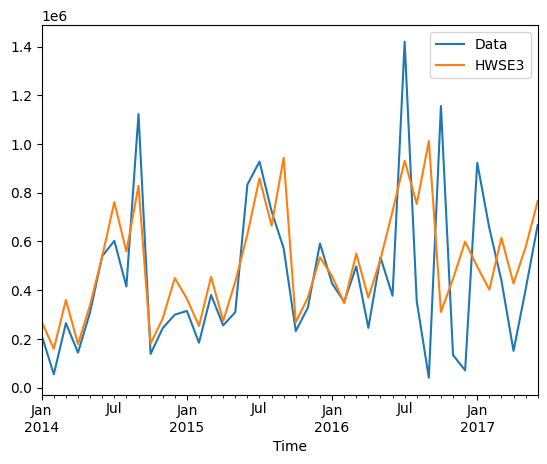

In [ ]:
from sklearn.metrics import mean_squared_error

data['Actuals'].plot(label='Data')
data['HWES3_ADD'].plot(label='HWSE3')
plt.legend()

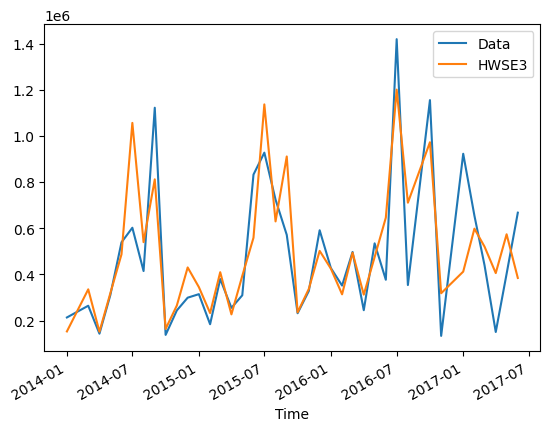

In [ ]:
data2['Actuals'].plot(label='Data')
data2['HWES3_ADD'].plot(label='HWSE3')
plt.legend()

In [ ]:
metrics(test_data['Actuals'],test_predictions['Actuals'])

Test Bias: -75621.667052
Test RMSE: 327477.544
Test RMSLE: 1.002
Test MAE: 288158.661720
Test mape: 1.779


In [ ]:
metrics(test_data2['Actuals'],test_predictions2['Actuals'])

Test Bias: 68639.973576
Test RMSE: 268677.017
Test RMSLE: 0.606
Test MAE: 211676.814028
Test mape: 0.552


# Forecasting the next 12 Months

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


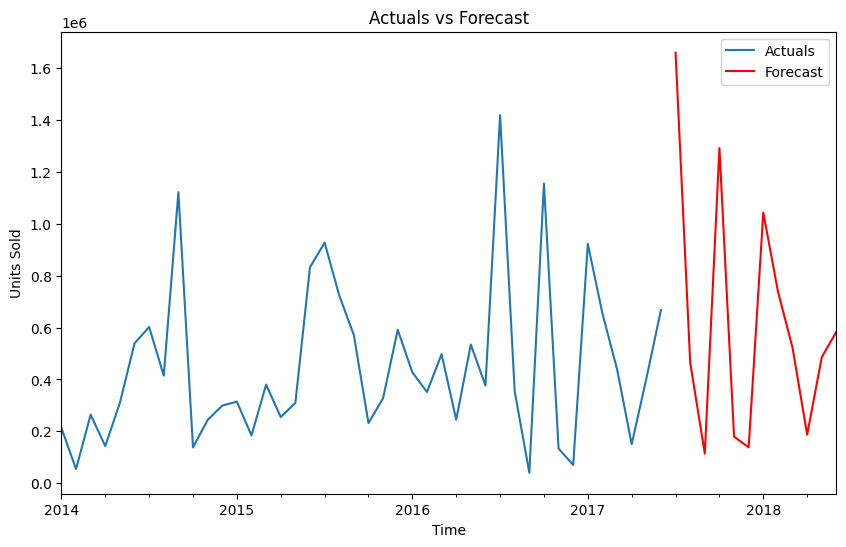

In [ ]:
# Train the model (assuming `data` is your complete dataset)
model = ExponentialSmoothing(data['Actuals'], trend='add', seasonal='mul', seasonal_periods=12).fit()

# Forecast for the next 12 months
forecast = model.forecast(12)




# Plotting
plt.figure(figsize=(10, 6))
data['Actuals'].plot(label='Actuals')
forecast.plot(label='Forecast', color='red')
plt.title('Actuals vs Forecast')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

In [ ]:
forecast

2017-07-01    1.660368e+06
2017-08-01    4.656075e+05
2017-09-01    1.139132e+05
2017-10-01    1.292521e+06
2017-11-01    1.794889e+05
2017-12-01    1.383392e+05
2018-01-01    1.043823e+06
2018-02-01    7.402249e+05
2018-03-01    5.226445e+05
2018-04-01    1.871629e+05
2018-05-01    4.858908e+05
2018-06-01    5.843437e+05
Freq: MS, dtype: float64

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


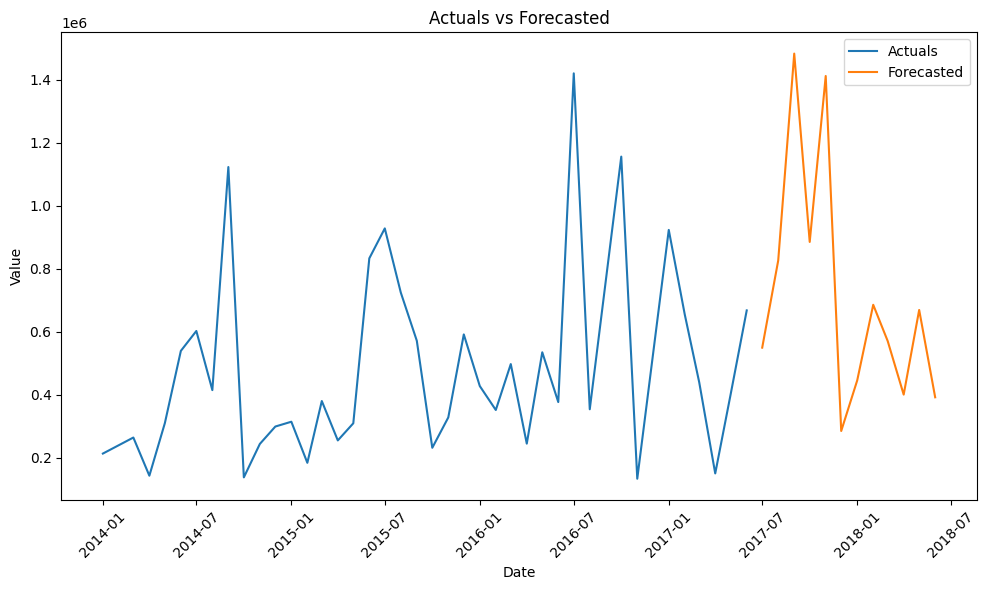

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Train the model (assuming `data` is your complete dataset)
model2 = ExponentialSmoothing(data2['Actuals'], trend='add', seasonal='mul', seasonal_periods=12).fit()

# Forecast for the next 12 months starting from July 1, 2017
forecast2 = model2.forecast(12)

# Define the start date for the forecast range
start_date = '2017-07-01'

# Create a date range for the forecasted period
date_range = pd.date_range(start=start_date, periods=12, freq='MS')

# Create a DataFrame with the forecasted values and date range
forecast_df = pd.DataFrame({'Date': date_range, 'Forecasted': forecast2})

# Set the 'Date' column as the index
forecast_df.set_index('Date', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=data2, x=data2.index, y='Actuals', label='Actuals')
sns.lineplot(data=forecast_df, x=forecast_df.index, y='Forecasted', label='Forecasted')
plt.title('Actuals vs Forecasted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
forecast2

39    5.495126e+05
40    8.261909e+05
41    1.482562e+06
42    8.849380e+05
43    1.411491e+06
44    2.850170e+05
45    4.456031e+05
46    6.855237e+05
47    5.706742e+05
48    4.005071e+05
49    6.691665e+05
50    3.919916e+05
dtype: float64

# ARIMA

In [ ]:
!pip install pmdarima
import pmdarima as pm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.9 MB/s eta 0:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     42 non-null     object 
 1   Actuals  42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


<Axes: >

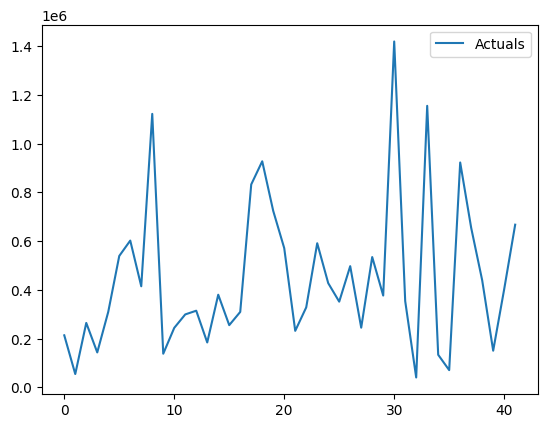

In [ ]:
df = pd.read_csv('Forecasting_Case_Study_Data.csv')
df = df.iloc[:42]
df.info()

df.plot()

In [ ]:
# Convert 'Time' to datetime and set it as index
df['Time'] = pd.to_datetime(df['Time'], format='%Y_Month_%m')
df.set_index('Time', inplace=True)

In [ ]:
df_train = df.iloc[:-int(len(df) * 0.2)]
df_test = df.iloc[-int(len(df) * 0.2):]

### Manual ARIMA (Manually picking the parameters (p,d,q))

### ACF and PACF Plots

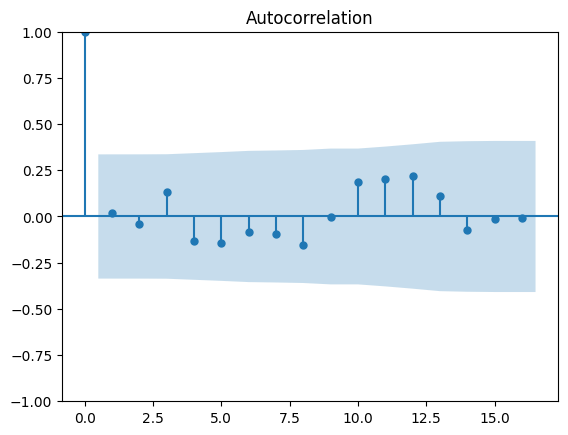

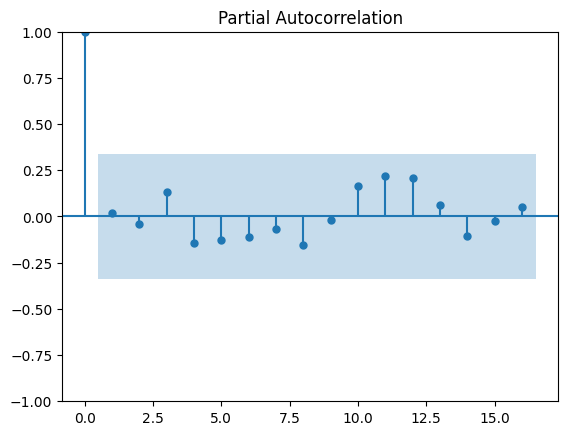

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots

acf_original = plot_acf(df_train)

pacf_original = plot_pacf(df_train)

case-1. ARIMA(p,d,0) ---> ACF is exponentially decaying or sinusoidal and there is significant lag at p and not beyond in PACF.

case-2. ARIMA(0,d,q) --->PACF is exponentially decaying or sinusoidal and there is significant lag at q and not beyond in ACF.



 Conclusion :  Since both these cases are equally followed, estimate the parameters to be (0, 0, 0)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order = (0,0,0))

model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Actuals   No. Observations:                   34
Model:                          ARIMA   Log Likelihood                -522.222
Date:                Fri, 12 Apr 2024   AIC                           1048.444
Time:                        02:47:08   BIC                           1051.497
Sample:                    01-01-2014   HQIC                          1049.485
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.529e+05   1.84e+06      0.246      0.806   -3.16e+06    4.06e+06
sigma2      3.389e+12    1.2e+12      2.832      0.005    1.04e+12    5.74e+12
Ljung-Box (L1) (Q):                   0.01   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


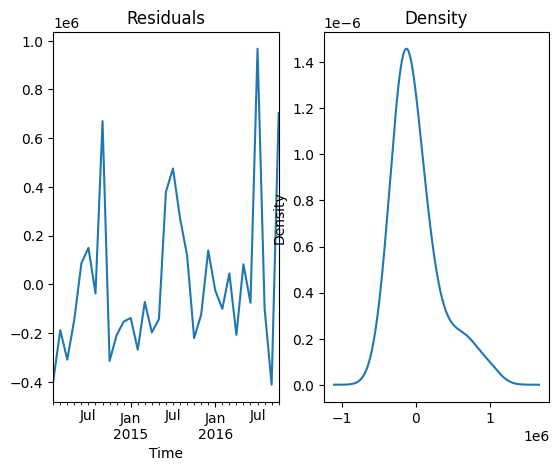

In [ ]:
import matplotlib.pyplot as plt

residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])

plt.show()

In [ ]:
residuals.mean()

7257.512477718339

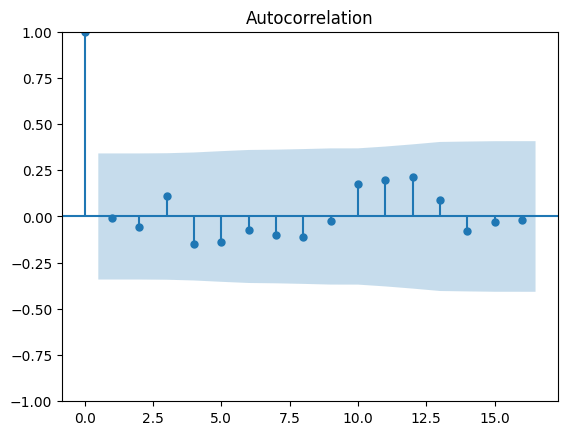

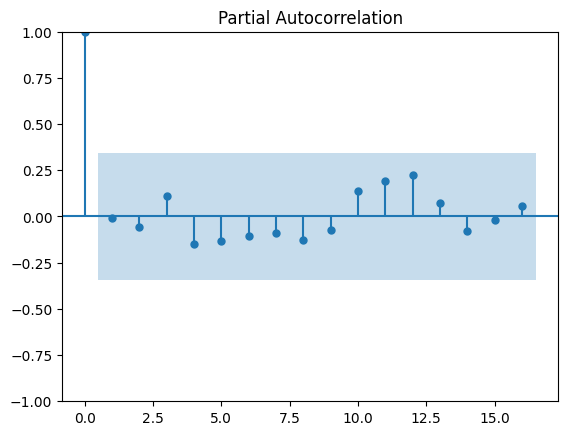

In [ ]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)


<Axes: xlabel='Time'>

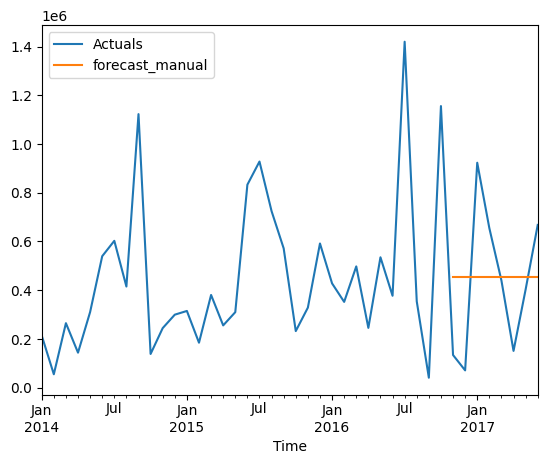

In [ ]:
forecast_test = model_fit.forecast(len(df_test))

df['forecast_manual'] = [None]*len(df_train) + list(forecast_test)

df.plot()

Model Evaluation

In [ ]:
# manual model

metrics(df_test['Actuals'], forecast_test)

Test Bias: -22706.911765
Test RMSE: 285102.901
Test RMSLE: 0.934
Test MAE: 244332.477941
Test mape: 1.390


Forecast For Next 1 year

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


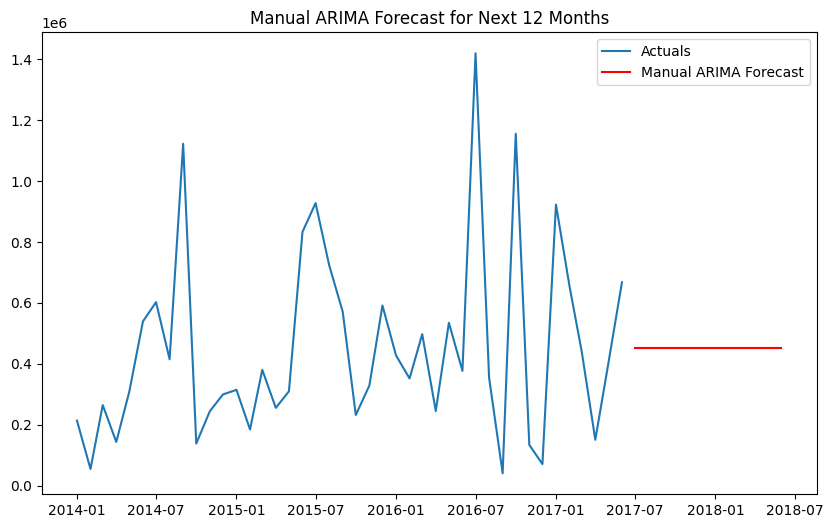

In [ ]:
# forecast for manual model
# Forecast the next 12 months
future_steps = 12
# forecast_values = model_fit.forecast(steps=future_steps)
forecast_values = model_fit.predict(start=len(df), end=len(df) + future_steps - 1, typ='levels')
# Generate a date range for the next 20 months starting after the test set
forecast_index = pd.date_range(start=df_test.index[-1] + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# Create a DataFrame for the forecasted values with the correct index alignment
forecast_df = pd.DataFrame({'ARIMA Forecast': forecast_values}, index=forecast_index)

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Actuals'], label='Actuals')
plt.plot(forecast_df.index, forecast_df['ARIMA Forecast'], label='Manual ARIMA Forecast', color='red')
plt.title('Manual ARIMA Forecast for Next 12 Months')
plt.legend()
plt.show()


### Seasonal ARIMA

In [ ]:
# with seasonality
sarima = pm.auto_arima(df_train, stepwise=False, seasonal=True, m=12)


In [ ]:
sarima

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(0, 1, 2, 12),
      suppress_warnings=True)

In [ ]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   34
Model:             SARIMAX(0, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                -306.856
Date:                                 Fri, 12 Apr 2024   AIC                            623.711
Time:                                         02:48:17   BIC                            629.167
Sample:                                     01-01-2014   HQIC                           624.996
                                          - 10-01-2016                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.407e+05   7.58e+04      1.857      0.063   -7842.602    2.89e+05
ma.L1         -0.5562      0.293     -1.897      0.058      -1.131       0.018
ma.S.L12      -0.1737      0.662     -0.262      0.793      -1.471       1.124
ma.S.L24      -0.3781      0.466     -0.812      0.417      -1.291       0.534
sigma2      1.059e+11      0.052   2.04e+12      0.000    1.06e+11    1.06e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.66   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.42   Prob(JB):                         0.86
Heteroskedasticity (H):               5.68   Skew:                            -0.22
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+28. Standard errors may be unstable.
"""

<Axes: xlabel='Time'>

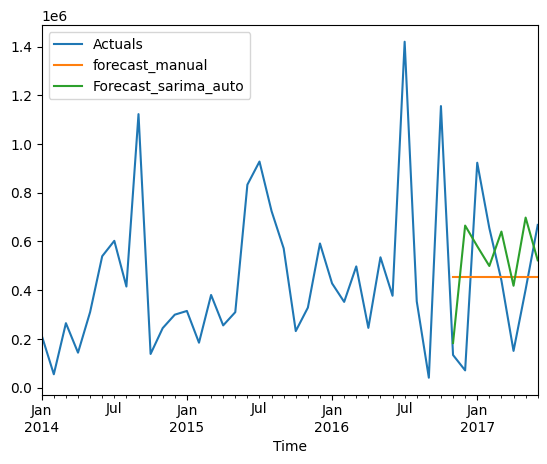

In [ ]:
forecast_test_sarima_auto = sarima.predict(n_periods = len(df_test))

df['Forecast_sarima_auto'] = [None]*len(df_train) + list(forecast_test_sarima_auto)

df.plot()

Evaluate The model


In [ ]:
# auto sarima model

print('Error metrics for seasonal arima model : \n')
metrics(df_test['Actuals'],forecast_test_sarima_auto)

Error metrics for seasonal arima model : 

Test Bias: -95491.214372
Test RMSE: 299519.619
Test RMSLE: 0.934
Test MAE: 256354.738011
Test mape: 1.575


Forecast For Next 1 year

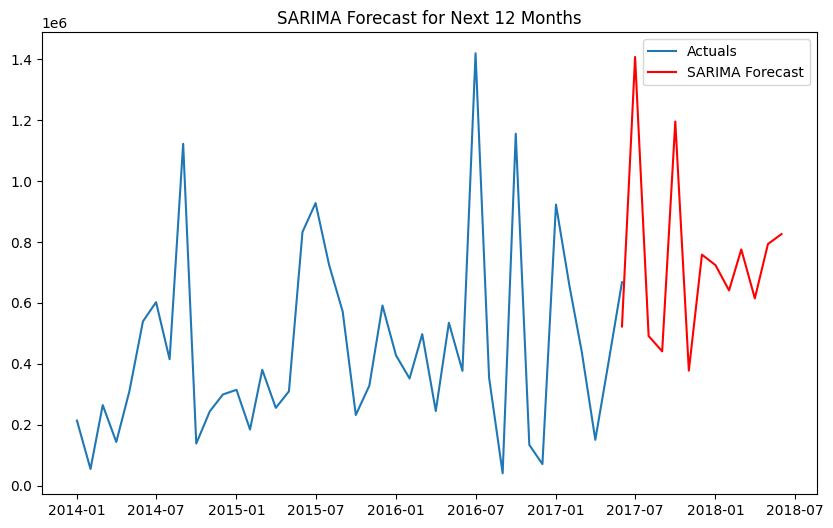

In [ ]:
# Forecast the next 12 months
future_steps = 20
forecast_values = sarima.predict(n_periods=future_steps)

# Get the last date in your existing data
last_date = df.index[-1]

# Generate a date range for the next 24 months starting from the last date in your data
forecast_index = pd.date_range(start=last_date , periods=future_steps, freq='MS')

# Create a DataFrame for the forecasted values with the correct index alignment
forecast_df = pd.DataFrame({'SARIMA Forecast': forecast_values}, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Actuals'], label='Actuals')
plt.plot(forecast_df.index, forecast_df['SARIMA Forecast'], label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast for Next 12 Months')
plt.legend()
plt.show()


In [ ]:
forecast_df[1:13]

,SARIMA Forecast
2017-07-01,1.407818e+06
2017-08-01,4.912741e+05
2017-09-01,4.407413e+05
2017-10-01,1.195677e+06
2017-11-01,3.775097e+05
2017-12-01,7.583798e+05
2018-01-01,7.240550e+05
2018-02-01,6.410486e+05
2018-03-01,7.756744e+05
2018-04-01,6.148331e+05


## Auto ARIMA

In [ ]:
import pmdarima as pm

auto_arima = pm.auto_arima(df_train, stepwise=False, trace=True, seasonal=False)
auto_arima


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=997.552, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=990.702, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=992.021, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=989.719, Time=0.09 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=993.613, Time=0.24 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=992.846, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=978.627, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=969.039, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=971.888, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=972.751, Time=0.09 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=973.859, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=976.126, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=970.856, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=973.236, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=974.380, Time=0.14 sec
 ARIMA(3,0,0)(0,0,0)[0]  

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -481.520
Date:                Fri, 12 Apr 2024   AIC                            969.039
Time:                        02:48:20   BIC                            973.618
Sample:                    01-01-2014   HQIC                           970.601
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9967      0.022     45.893      0.000       0.954       1.039
ma.L1         -0.8972      0.273     -3.291      0.001      -1.431      -0.363
sigma2      1.334e+11   4.17e-13    3.2e+23      0.000    1.33e+11    1.33e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                 7.54
Prob(Q):                              0.69   Prob(JB):                         0.02
Heteroskedasticity (H):               1.73   Skew:                             1.06
Prob(H) (two-sided):                  0.38   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.36e+39. Standard errors may be unstable.
"""

<Axes: xlabel='Time'>

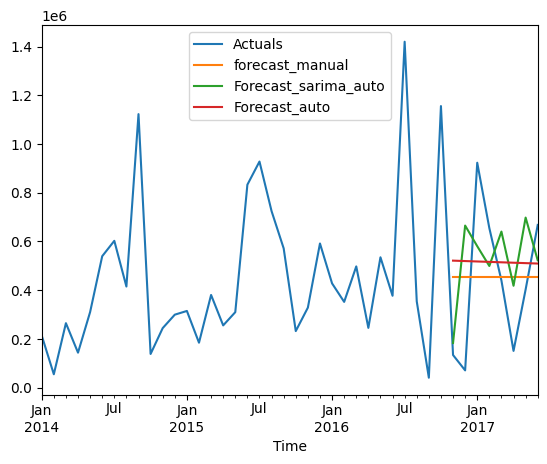

In [ ]:
forecast_test_auto = auto_arima.predict(n_periods = len(df_test))

df['Forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

df.plot()

### Evaluate the Model

In [ ]:
# auto model

print('Error metrics for auto model : \n')
metrics(df_test['Actuals'],forecast_test_auto)

Error metrics for auto model : 

Test Bias: -84845.820564
Test RMSE: 297647.850
Test RMSLE: 0.993
Test MAE: 260506.698011
Test mape: 1.625


### Forecast for next 1 year

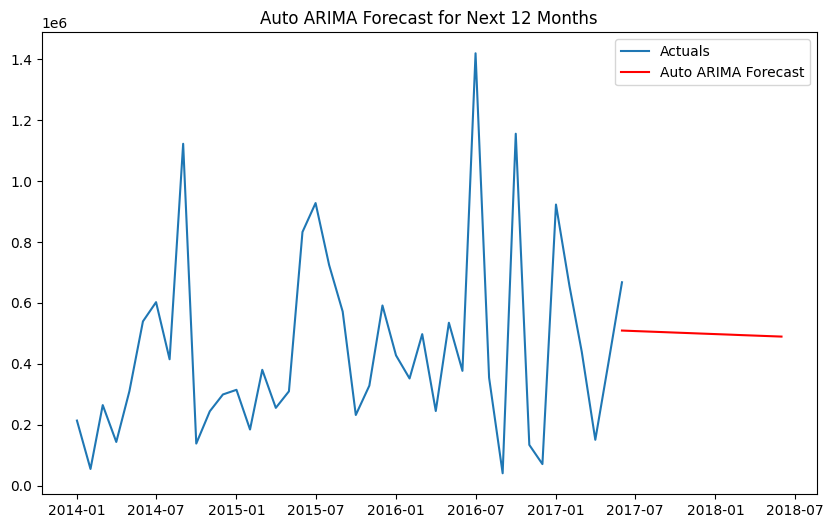

In [ ]:
#  forecast for auto model
# Forecast the next 12 months
future_steps = 20
forecast_values = auto_arima.predict(n_periods=future_steps)

#pd.DateOffset(months=1)
forecast_index = pd.date_range(start=df.index[-1] , periods=future_steps, freq='MS')

# Create a DataFrame for the forecasted values with the correct index alignment
forecast_df = pd.DataFrame({'ARIMA Forecast': forecast_values}, index=forecast_index)

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Actuals'], label='Actuals')
plt.plot(forecast_df.index, forecast_df['ARIMA Forecast'], label='Auto ARIMA Forecast', color='red')
plt.title('Auto ARIMA Forecast for Next 12 Months')
plt.legend()
plt.show()


#LSTM

## Single-layer LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
data = pd.read_csv('Forecasting_Case_Study_Data.csv')
data = data.iloc[:42]
from datetime import datetime

# Convert 'Time' to datetime and set it as index
data['Time'] = pd.to_datetime(data['Time'], format='%Y_Month_%m')
data.set_index('Time', inplace=True)

data.to_csv('Forecasting_Date_Time.csv',index=False)

In [ ]:
# Removing 3 outliers - 40k,50k,70k
data2=pd.read_csv('Forecasting_Case_Study_Data_2.csv')
data2 = data2.iloc[:39]
data2.to_csv('Without_Outlier.csv',index=False)
data2['Time'] = pd.to_datetime(data2['Time'], format='%Y_Month_%m')
data2.set_index('Time', inplace=True)

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaler2 = MinMaxScaler()
scaled_data2 = scaler2.fit_transform(data2)
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 12  # You can adjust this based on your preference

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)

X2, y2 = create_sequences(scaled_data2, sequence_length)

In [ ]:
# Split the data into training and testing sets
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

X_train2, X_test2 = X2[:-12], X2[-12:]
y_train2, y_test2 = y2[:-12], y2[-12:]

In [ ]:
# Construct the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model2 = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train2.shape[1], X_train2.shape[2])),
    Dense(1)
])


model.compile(optimizer='adam', loss='mse')
model2.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)
history2 = model2.fit(X_train2, y_train2, epochs=100, batch_size=12, verbose=1)

Epoch 1/100
2/2 [==============================] - 2s 19ms/step - loss: 0.1168
Epoch 2/100
2/2 [==============================] - 0s 9ms/step - loss: 0.1060
Epoch 3/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0965
Epoch 4/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0871
Epoch 5/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0793
Epoch 6/100
2/2 [==============================] - 0s 9ms/step - loss: 0.0710
Epoch 7/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0642
Epoch 8/100
2/2 [==============================] - 0s 13ms/step - loss: 0.0576
Epoch 9/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0507
Epoch 10/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0443
Epoch 11/100
2/2 [==============================] - 0s 10ms/step - loss: 0.0390
Epoch 12/100
2/2 [==============================] - 0s 11ms/step - loss: 0.0342
Epoch 13/100
2/2 [==============================] -

In [ ]:
# Forecast future demand
forecast = model.predict(X_test)
forecast2 = model2.predict(X_test2)

1/1 [==============================] - 0s 175ms/step


In [ ]:
forecast = scaler.inverse_transform(forecast)
forecast2 = scaler2.inverse_transform(forecast2)

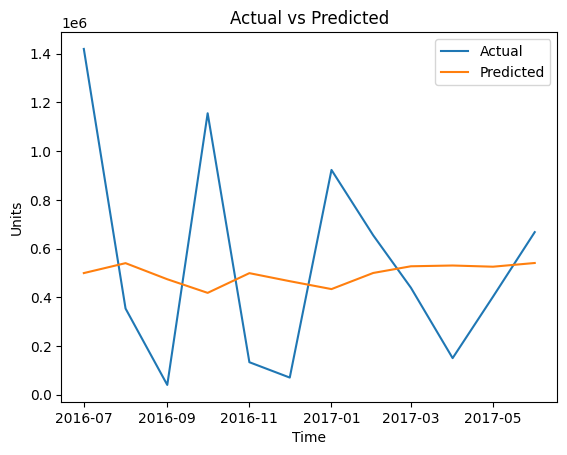

In [ ]:
# Plotting actual vs predicted values
plt.plot(data.index[-12:], data[-12:], label='Actual')
plt.plot(data.index[-12:], forecast, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Units')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

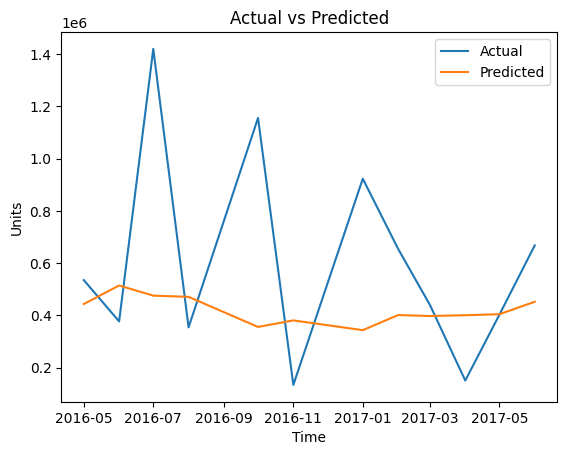

In [ ]:
# Plotting actual vs predicted values for data without outliers
plt.plot(data2.index[-12:], data2[-12:], label='Actual')
plt.plot(data2.index[-12:], forecast2, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Units')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

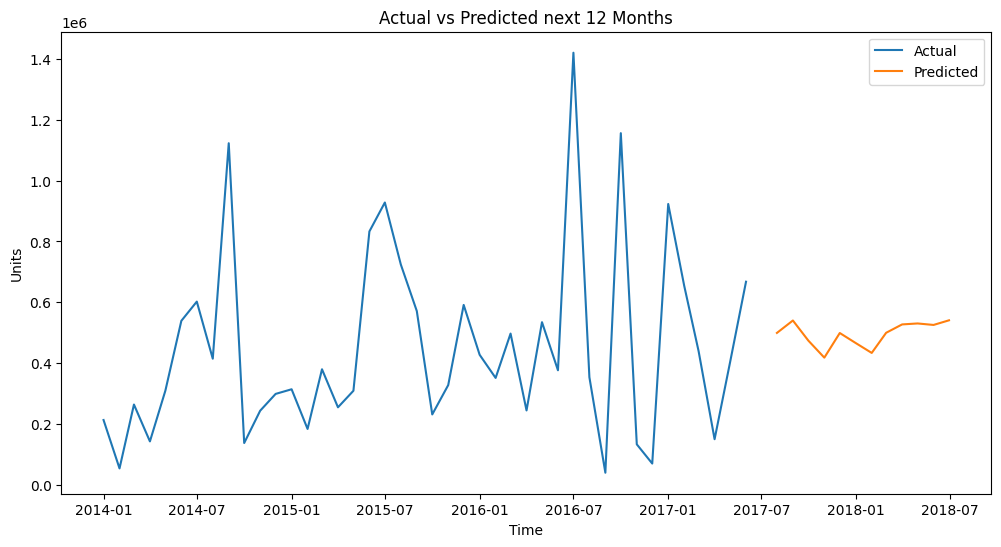

In [ ]:
forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=len(forecast), freq='M')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecasted'])

# Concatenate the forecast DataFrame with the original data
combined_data = pd.concat([data, forecast_df])

# Plotting actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Actuals'], label='Actual')
plt.plot(combined_data.index[-12:], combined_data['Forecasted'][-12:], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Units')
plt.title('Actual vs Predicted next 12 Months')
plt.legend()
plt.show()

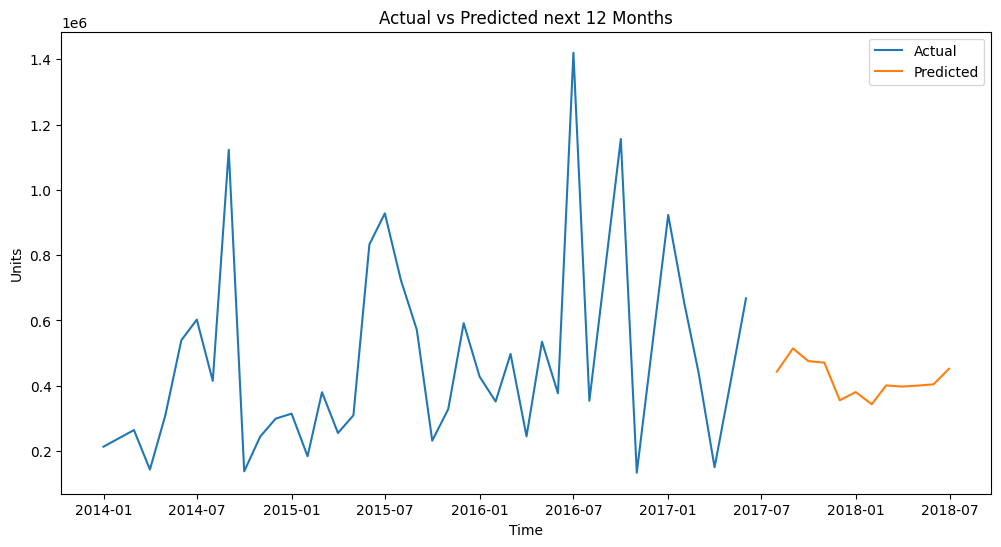

In [ ]:
forecast_index2 = pd.date_range(start=data2.index[-1] + pd.DateOffset(months=1), periods=len(forecast2), freq='M')
forecast_df2 = pd.DataFrame(forecast2, index=forecast_index2, columns=['Forecasted'])

# Concatenate the forecast DataFrame with the original data
combined_data2 = pd.concat([data2, forecast_df2])

# Plotting actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(combined_data2.index, combined_data2['Actuals'], label='Actual')
plt.plot(combined_data2.index[-12:], combined_data2['Forecasted'][-12:], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Units')
plt.title('Actual vs Predicted next 12 Months')
plt.legend()
plt.show()

In [ ]:
print("Original Dataset")
metrics(data[-12:].values, forecast)
print()
print("Without Outliers")
metrics(data2[-12:].values, forecast2)

Original Dataset
Test Bias: 37942.802083
Test RMSE: 442601.340
Test RMSLE: 1.157
Test MAE: 366765.656250
Test mape: 2.076

Without Outliers
Test Bias: 181201.466146
Test RMSE: 422841.805
Test RMSLE: 0.721
Test MAE: 306686.117188
Test mape: 0.598


<ipython-input-21-cd0694219c88>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Test Bias: %f' % bias)
<ipython-input-21-cd0694219c88>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Test Bias: %f' % bias)


##Multi-layer LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
data = pd.read_csv('Forecasting_Case_Study_Data.csv')
data = data.iloc[:42]
from datetime import datetime

# Convert 'Time' to datetime and set it as index
data['Time'] = pd.to_datetime(data['Time'], format='%Y_Month_%m')
data.set_index('Time', inplace=True)

data.to_csv('Forecasting_Date_Time.csv',index=False)

In [ ]:
# Removing 3 outliers - 40k,50k,70k
data2=pd.read_csv('Forecasting_Case_Study_Data_2.csv')
data2 = data2.iloc[:39]
data2.to_csv('Without_Outlier.csv',index=False)
data2['Time'] = pd.to_datetime(data2['Time'], format='%Y_Month_%m')
data2.set_index('Time', inplace=True)

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

scaler2 = MinMaxScaler()
scaled_data2 = scaler2.fit_transform(data2)
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
# Define sequence length
sequence_length = 12  # You can adjust this based on your preference

# Create sequences
X, y = create_sequences(scaled_data, sequence_length)
X2, y2 = create_sequences(scaled_data2, sequence_length)

In [ ]:
# Split the data into training and testing sets
X_train, X_test = X[:-12], X[-12:]
y_train, y_test = y[:-12], y[-12:]

X_train2, X_test2 = X2[:-12], X2[-12:]
y_train2, y_test2 = y2[:-12], y2[-12:]

In [ ]:
# Construct the LSTM model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model2 = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train2.shape[1], X_train2.shape[2])),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model2.compile(optimizer='adam', loss='mse')


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=12, verbose=1)
history2 = model2.fit(X_train2, y_train2, epochs=200, batch_size=12, verbose=1)

Epoch 1/200
2/2 [==============================] - 5s 39ms/step - loss: 0.1098
Epoch 2/200
2/2 [==============================] - 0s 36ms/step - loss: 0.0998
Epoch 3/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0900
Epoch 4/200
2/2 [==============================] - 0s 20ms/step - loss: 0.0766
Epoch 5/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0640
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.0521
Epoch 7/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0374
Epoch 8/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0293
Epoch 9/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0303
Epoch 10/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0328
Epoch 11/200
2/2 [==============================] - 0s 21ms/step - loss: 0.0405
Epoch 12/200
2/2 [==============================] - 0s 22ms/step - loss: 0.0213
Epoch 13/200
2/2 [==============================]

In [ ]:
# Forecast future demand
forecast = model.predict(X_test)
forecast2 = model2.predict(X_test2)


1/1 [==============================] - 0s 438ms/step


In [ ]:
# Inverse transform the scaled forecast data
forecast = scaler.inverse_transform(forecast)
forecast2 = scaler2.inverse_transform(forecast2)

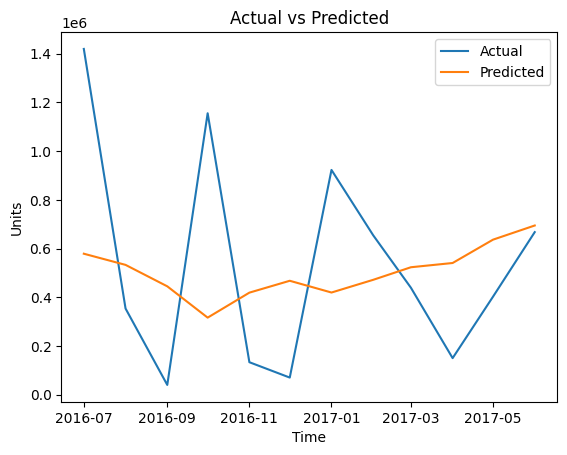

In [ ]:
# Plotting actual vs predicted values
plt.plot(data.index[-12:], data[-12:], label='Actual')
plt.plot(data.index[-12:], forecast, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Units')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

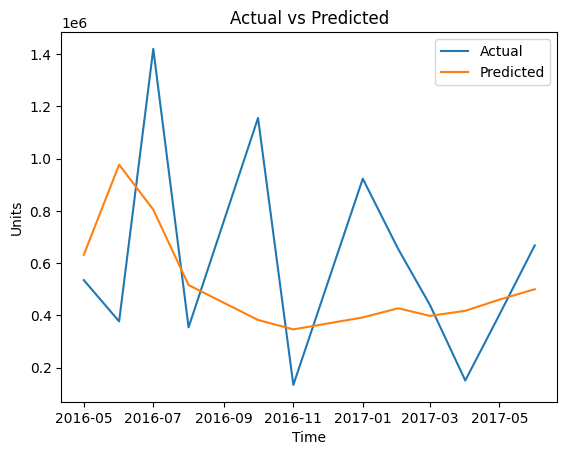

In [ ]:
# Plotting actual vs predicted values (data without outliers)
plt.plot(data2.index[-12:], data2[-12:], label='Actual')
plt.plot(data2.index[-12:], forecast2, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Units')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

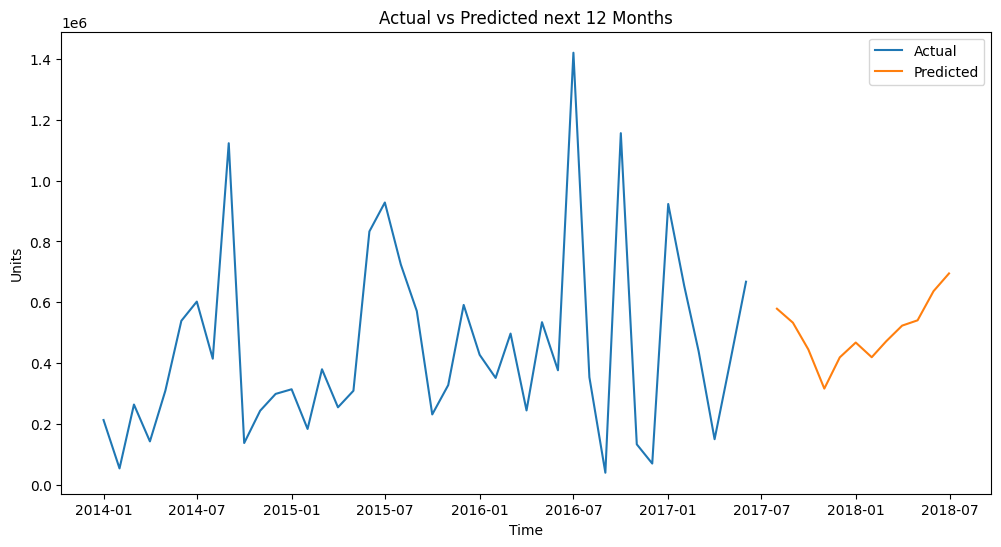

In [ ]:
forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=len(forecast), freq='M')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecasted'])

# Concatenate the forecast DataFrame with the original data
combined_data = pd.concat([data, forecast_df])

# Plotting actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Actuals'], label='Actual')
plt.plot(combined_data.index[-12:], combined_data['Forecasted'][-12:], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Units')
plt.title('Actual vs Predicted next 12 Months')
plt.legend()
plt.show()

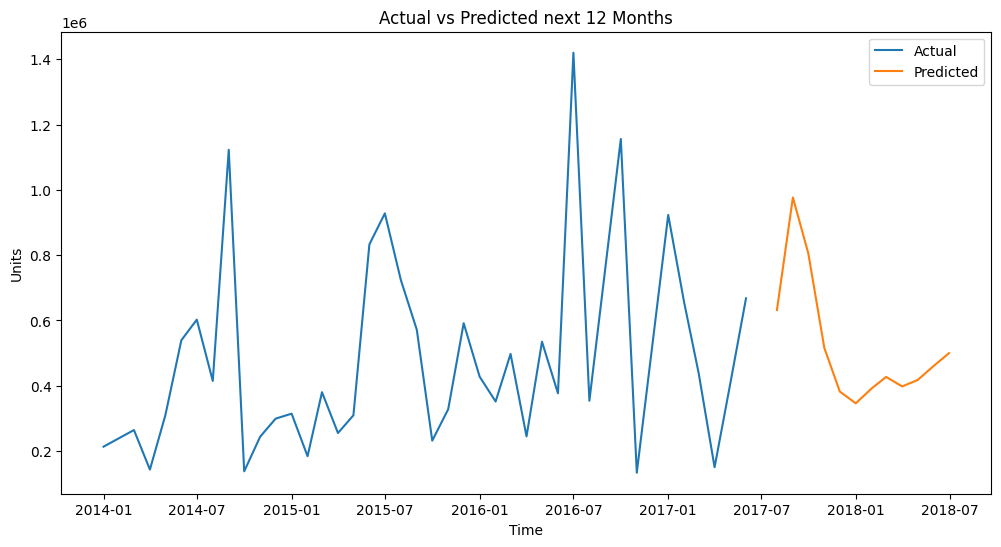

In [ ]:
#without outliers
forecast_index2 = pd.date_range(start=data2.index[-1] + pd.DateOffset(months=1), periods=len(forecast2), freq='M')
forecast_df2 = pd.DataFrame(forecast2, index=forecast_index2, columns=['Forecasted'])

# Concatenate the forecast DataFrame with the original data
combined_data2 = pd.concat([data2, forecast_df2])

# Plotting actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(combined_data2.index, combined_data2['Actuals'], label='Actual')
plt.plot(combined_data2.index[-12:], combined_data2['Forecasted'][-12:], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Units')
plt.title('Actual vs Predicted next 12 Months')
plt.legend()
plt.show()

In [ ]:

print("Original Dataset")
metrics(data[-12:].values, forecast)
print()
print("Without Outliers")
metrics(data2[-12:].values, forecast2)

Original Dataset
Test Bias: 30246.375000
Test RMSE: 442369.615
Test RMSLE: 1.152
Test MAE: 364068.515625
Test mape: 1.989

Without Outliers
Test Bias: 80070.325521
Test RMSE: 393253.274
Test RMSLE: 0.683
Test MAE: 312723.028646
Test mape: 0.676


<ipython-input-21-cd0694219c88>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Test Bias: %f' % bias)
<ipython-input-21-cd0694219c88>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Test Bias: %f' % bias)
